In [6]:
# 连接 google drive    use path+ directory
import os
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive/COMP3710/project/ISIC2018_dataset"

os.chdir(path)
os.listdir(path)

Mounted at /content/drive


['validation', 'train', 'test', 'try3unet_membrane.hdf5', 'unet_membrane.hdf5']

In [7]:
import os
import sys
import random
import warnings

import numpy as np


import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

BATCH_SIZE = 10 # the higher the better
IMG_WIDTH = 128 # for faster computing on kaggle
IMG_HEIGHT = 128 # for faster computing on kaggle
IMG_CHANNELS = 3


In [8]:
gpu_device_name = tf.test.gpu_device_name()
print(gpu_device_name)

tf.test.is_gpu_available()

/device:GPU:0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [9]:
from keras.preprocessing.image import ImageDataGenerator
def trainGenerator(batch_size, train_path, image_folder, mask_folder, data_gen_args, target_size = (128,128),
                   seed = 2):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''

    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_path,#训练数据文件夹路径
        classes = [image_folder],#类别文件夹,对哪一个类进行增强
        color_mode = "rgb",
        class_mode = None,#不返回标签
        target_size = target_size,#读取文件顺便resize的尺寸
        batch_size = batch_size,#每次产生的（进行转换的）图片张数
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        color_mode = "grayscale",
        class_mode = None,
        target_size = target_size,
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)#组合成一个生成器

    for (img,mask) in train_generator:   
        '''
        img:(5,384,511,3)   0-255
        mask:(5,384,511,1)
        '''
        img = img/255.0
        mask = mask/255.0
        mask[mask>0.5] = 1
        mask[mask<=0.5] = 0
        
        yield (img,mask)
    

In [10]:
from keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())


# Build U-Net model
from keras.models import *
from keras.layers import *
from keras.optimizers import *



inputs = Input((128,128,3))
#  2D卷积层
conv1 = BatchNormalization()(Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs))
conv1 = BatchNormalization()(Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1))
#  对于空间数据的最大池化
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = BatchNormalization()(Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1))
conv2 = BatchNormalization()(Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2))
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = BatchNormalization()(Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2))
conv3 = BatchNormalization()(Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3))
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = BatchNormalization()(Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3))
conv4 = BatchNormalization()(Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4))
#  Dropout正规化，防止过拟合
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = BatchNormalization()(Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4))
conv5 = BatchNormalization()(Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5))
drop5 = Dropout(0.5)(conv5)
#  上采样之后再进行卷积，相当于转置卷积操作
up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))

try:
    merge6 = concatenate([drop4,up6],axis = 3)
except:
    merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
conv6 = BatchNormalization()(Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6))
conv6 = BatchNormalization()(Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6))

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
try:
    merge7 = concatenate([conv3,up7],axis = 3)
except:
    merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
conv7 = BatchNormalization()(Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7))
conv7 = BatchNormalization()(Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7))

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
try:
    merge8 = concatenate([conv2,up8],axis = 3)
except:
    merge8 = merge([conv2,up8],mode = 'concat', concat_axis = 3)
conv8 = BatchNormalization()(Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8))
conv8 = BatchNormalization()(Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8))

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
try:
    merge9 = concatenate([conv1,up9],axis = 3)
except:
    merge9 = merge([conv1,up9],mode = 'concat', concat_axis = 3)
conv9 = BatchNormalization()(Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9))
conv9 = BatchNormalization()(Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9))
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(inputs = inputs, outputs = conv10)

#  用于配置训练模型（优化器、目标函数、模型评估标准）
# model.compile(optimizer=Adam(lr = 1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=Adam(lr = 3e-4), loss='binary_crossentropy', metrics=[dice_coef])
#  如果有预训练的权重


# model.summary()

In [11]:
# Build U-Net model
from keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())


# Build U-Net model
from keras.models import *
from keras.layers import *
from keras.optimizers import *



inputs = Input((128,128,3))


c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=Adam(lr = 3e-4), loss='binary_crossentropy', metrics=[dice_coef])


In [12]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')#数据增强时的变换方式的字典

print(type(data_gen_args))

X_train = trainGenerator(20,path+'//train','image','label',data_gen_args)
validation_data = trainGenerator(10,path+'//validation','image','label',data_gen_args)

model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)
#回调函数，第一个是保存模型路径，第二个是检测的值，检测Loss是使它最小，第三个是只保存在验证集上性能最好的模型
model.fit_generator(X_train,steps_per_epoch=80,epochs=25,callbacks=[model_checkpoint],
                    validation_data = validation_data,
                validation_steps = 60    )
#steps_per_epoch指的是每个epoch有多少个batch_size，也就是训练集总样本数/batch_size
# validation steps = validation data /batch_size

<class 'dict'>
Instructions for updating:
Please use Model.fit, which supports generators.
Found 1900 images belonging to 1 classes.
Found 1900 images belonging to 1 classes.
Epoch 1/25
80/80 [==============================] - ETA: 0s - loss: 0.4174 - dice_coef: 0.3075 Found 600 images belonging to 1 classes.
Found 600 images belonging to 1 classes.

Epoch 00001: loss improved from inf to 0.41742, saving model to unet_membrane.hdf5
80/80 [==============================] - 1480s 19s/step - loss: 0.4174 - dice_coef: 0.3075 - val_loss: 0.4062 - val_dice_coef: 0.4181
Epoch 2/25
80/80 [==============================] - ETA: 0s - loss: 0.2901 - dice_coef: 0.5807
Epoch 00002: loss improved from 0.41742 to 0.29010, saving model to unet_membrane.hdf5
80/80 [==============================] - 299s 4s/step - loss: 0.2901 - dice_coef: 0.5807 - val_loss: 0.3659 - val_dice_coef: 0.4831
Epoch 3/25
80/80 [==============================] - ETA: 0s - loss: 0.2226 - dice_coef: 0.6800
Epoch 00003: loss imp

Found 94 images belonging to 1 classes.


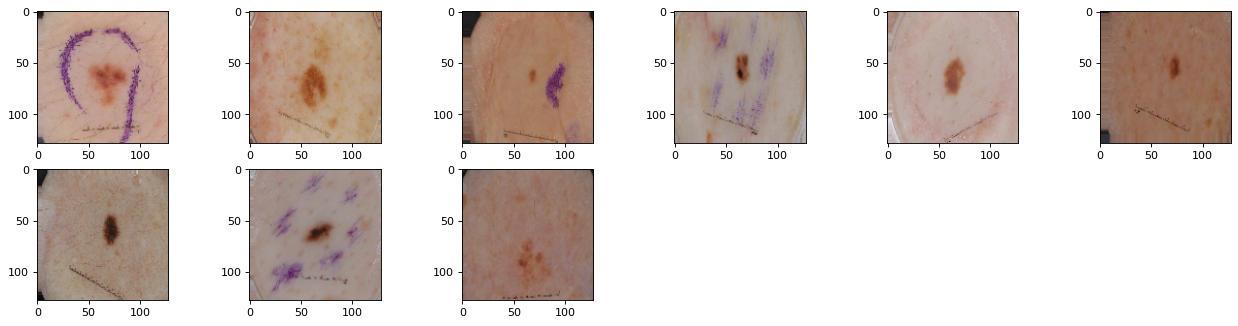

1/1 [==============================] - 0s 7ms/step


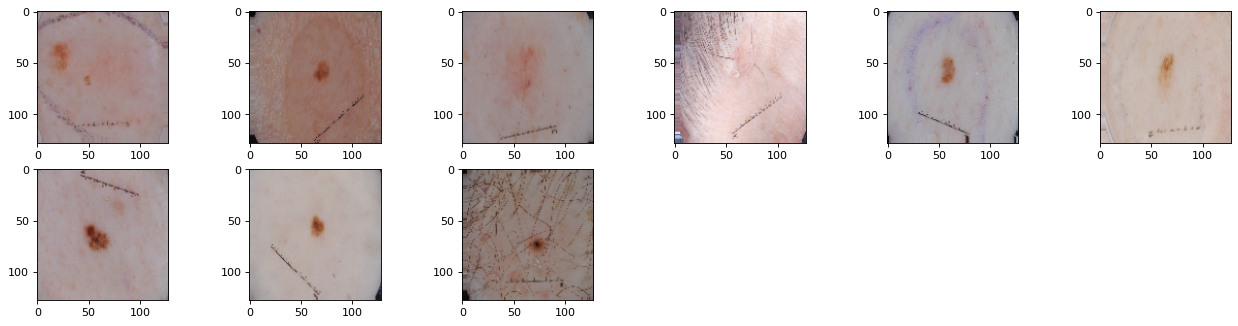

In [27]:
from PIL import Image
def testGenerator(batch_size, train_path, image_folder, data_gen_args, target_size = (128,128),
                   seed = 2):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''

    image_datagen = ImageDataGenerator(**data_gen_args)
    
    
    image_generator = image_datagen.flow_from_directory(
        train_path,#训练数据文件夹路径
        classes = [image_folder],#类别文件夹,对哪一个类进行增强
        color_mode = "rgb",
        class_mode = None,#不返回标签
        target_size = target_size,#读取文件顺便resize的尺寸
        batch_size = batch_size,#每次产生的（进行转换的）图片张数
        seed = seed)
    
    for img in image_generator:
      img = np.trunc(img)
      img = img.astype(int)
      plt.figure(figsize=(20,10), dpi=80)
      for i in range(1,batch_size):
        plt.subplot(4,6,i)
        plt.imshow(img[i-1,:,:,:])
      plt.show()

      yield img


testGene = testGenerator(10,path+"//test",'image',data_gen_args)
results = model.predict_generator(testGene,1,verbose=1)

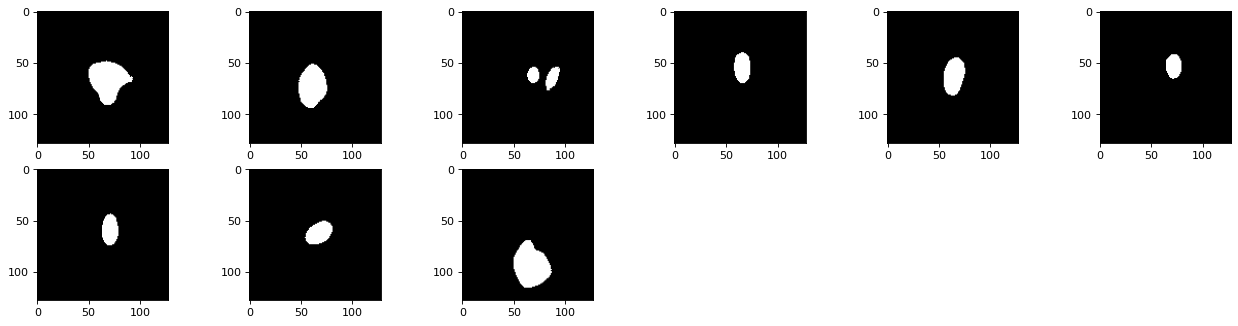

In [28]:

plt.figure(figsize=(20,10), dpi=80)
for p in range(1,10):
  plt.subplot(4,6,p)
  plt.imshow(results[p-1,:,:,0],cmap = "gray")
plt.show()



In [14]:
# save model
results.save("/unet_for_ISIC.h5")